# MLToolKit Model Explainer Example

Apache License, Version 2.0 (http://www.apache.org/licenses/LICENSE-2.0)

### Current release: PyMLToolKit [v0.1.10]

MLToolkit (mltk) is a Python package providing a set of user-friendly functions to help building machine learning models in data science research, teaching or production focused projects. MLToolkit supports all stages of the machine learning application development process.

### Installation
```
pip install pymltoolkit
```
If the installation failed with dependancy issues, execute the above command with --no-dependencies

```
pip install pymltoolkit --no-dependencies
```

In [1]:
import mltk

mltk==0.1.10

Some functions of MLToolKit depends on number of Open Source Python Libraries such as
- Data Manipulation : Pandas
- Machine Learning: Statsmodels, Scikit-learn, Catboost
- Deep Learning: Tensorflow, 
- Model Interpretability: Shap, Lime
- Server Framework: Flask
- Text Processing: BeautifulSoup, TextLab
- Database Connectivity: SQLAlchemy, PyODBC
MLToolkit Project acknowledge the creators and contributors of the above libraries for their contribution to the Open Source Community.



## ETL Function

In [2]:
def ETL(DataFrame, variables_setup_dict=None):
    # Add ID column
    DataFrame = mltk.add_identity_column(DataFrame, id_label='ID', start=1, increment=1)
    
    # Clean column names
    DataFrame = mltk.clean_column_names(DataFrame, replace='')
    input_columns = list(DataFrame.columns)

    variables_setup_dict = """   
    {
        "setting":"score",

        "variables": {            
                "category_variables" : ["sex", "race", "occupation", "workclass", "maritalstatus", "relationship"],
                "binary_variables": [],
                "target_variable":"HighIncome"
        },

        "preprocess_tasks": [
            {
                "type": "transform",
                "out_type":"cnt",
                "include": false,
                "operation": "normalize",
                "variables": {
                    "source": "age",
                    "destination": "normalizedage"
                },
                "parameters": {
                    "method": "zscore"
                }
            },
            {
                "type": "category_merge",
                "out_type":"cat",
                "include": true,
                "operation": "catmerge",
                "variables": {
                    "source": "maritalstatus",
                    "destination": "maritalstatus"
                },
                "parameters": {
                    "group_value": "Married",
                    "values": [ "Married-civ-spouse", "Married-spouse-absent", "Married-AF-spouse" ]
                }
            },
            {
                "type": "entity",
                "out_type":"cat",
                "include": true,
                "operation": "dictionary",
                "variables": {
                    "source": "nativecountry",
                    "destination": "nativecountryGRP"
                },
                "parameters": {
                    "match_type": null,
                    "dictionary": [
                        {
                            "entity": "USA",
                            "values": [ "United-States" ],
                            "case": true
                        },
                        {
                            "entity": "Canada",
                            "values": [ "Canada" ],
                            "case": true
                        },
                        {
                            "entity": "OtherAmericas",
                            "values": [ "South", "Mexico", "Trinadad&Tobago", "Jamaica", "Peru", "Nicaragua", "Dominican-Republic", "Haiti", "Ecuador", "El-Salvador", "Columbia", "Honduras", "Guatemala", "Puerto-Rico", "Cuba", "Outlying-US(Guam-USVI-etc)"],
                            "case": true
                        },
                        {
                            "entity": "Europe-Med",
                            "values": [ "Greece", "Holand-Netherlands", "Poland", "Iran", "England", "Germany", "Italy", "Ireland", "Hungary", "France", "Yugoslavia", "Scotland", "Portugal" ],
                            "case": true
                        },
                        {
                            "entity": "Asia",
                            "values": [ "Vietnam", "China", "Taiwan", "India", "Philippines", "Japan", "Hong", "Cambodia", "Laos", "Thailand" ],
                            "case": true
                        },
                        {
                            "entity": "Other",
                            "values": [ "?" ],
                            "case": true
                        }
                    ],
                    "null": "NA",
                    "default": "OTHER"
                }
            },
            {
                "type": "category",
                "out_type":"cat",
                "include": true,
                "operation": "bucket",
                "variables": {
                    "source": "age",
                    "destination": null
                },
                "parameters": {
                    "labels_str": [ "0", "20", "30", "40", "50", "60", "INF" ],
                    "right_inclusive": true,
                    "default": "OTHER",
                    "null": "NA"
                }
            },
            {
                "type": "category",
                "out_type":"cat",
                "include": true,
                "operation": "bucket",
                "variables": {
                    "source": "educationnum",
                    "destination": null
                },
                "parameters": {
                    "labels_str": [ "1", "5", "8", "9", "12", "16" ],
                    "right_inclusive": true,
                    "default": "OTHER",
                    "null": "NA"
                }
            },
            {
                "type": "category",
                "out_type":"cat",
                "include": true,
                "operation": "bucket",
                "variables": {
                    "source": "hoursperweek",
                    "destination": null
                },
                "parameters": {
                    "labels_str": [ "0", "20", "35", "40", "60", "INF" ],
                    "right_inclusive": true,
                    "default": "OTHER",
                    "null": "NA"
                }
            }
        ]
    }
    """
    
    DataFrame, categoryVariables, binaryVariables, targetVariable = mltk.setup_variables_task(DataFrame, variables_setup_dict)
    
    # Create One Hot Encoded Variables
    DataFrame, featureVariables, targetVariable = mltk.to_one_hot_encode(DataFrame, category_variables=categoryVariables, binary_variables=binaryVariables, target_variable=targetVariable)

    return DataFrame, input_columns

## Load Model

In [3]:
saveFilePath = r'INCOMELEVELRF20191231110921.pkl'
MLModelObject = mltk.load_model(saveFilePath)

TestInput = """
{
      "ID": "A001",
      "age": 32,
      "workclass": "Private",
      "education": "Doctorate",
      "education-num": 16,
      "marital-status": "Married-civ-spouse",
      "occupation": "Prof-specialty",
      "relationship": "Husband",
      "race": "Asian-Pac-Islander",
      "sex": "Male",
      "capital-gain": 0,
      "capital-loss": 0,
      "hours-per-week": 40,
      "native-country": "?"
}
"""

Loading model from file INCOMELEVELRF20191231110921.pkl


## Score

In [4]:
output = mltk.score_records(TestInput, MLModelObject, edges=None, ETL=ETL, return_type='frame') # Other options for return_type, {'json', 'frame'}
output

Column ID exists in the DataFrame


,ID,age,capitalgain,capitalloss,education,educationnum,hoursperweek,maritalstatus,nativecountry,occupation,race,relationship,sex,workclass,Probability,Score,Predicted
0,A001,32,0,0,Doctorate,16,40,Married,?,Prof-specialty,Asian-Pac-Islander,Husband,Male,Private,0.53248,9,1


## Prepare Datset to Explain

In [5]:
DataFrame = ETL(output)[0]
DataFrame

Column ID exists in the DataFrame


,ID,age,capitalgain,capitalloss,education,educationnum,hoursperweek,maritalstatus,nativecountry,occupation,race,relationship,sex,workclass,Probability,Score,Predicted,HighIncome,normalizedage,nativecountryGRP,ageGRP,educationnumGRP,hoursperweekGRP,workclass_Private,maritalstatus_Married,occupation_Prof-specialty,nativecountryGRP_Other,race_Asian-Pac-Islander,sex_Male,"educationnumGRP_5_(12,16]","hoursperweekGRP_3_(35,40]","ageGRP_3_(30,40]",relationship_Husband
0,A001,32,0,0,Doctorate,16,40,Married,?,Prof-specialty,Asian-Pac-Islander,Husband,Male,Private,0.53248,9,1,None,NaN,Other,"3_(30,40]","5_(12,16]","3_(35,40]",1,1,1,1,1,1,1,1,1,1


## Explain Model Output

### Create Explainer (Shap)

In [6]:
Explainer = mltk.build_explainer(MLModelObject, explainer_config={'IdColumns':['ID'], 'Method':'shap', 'ClassNumber':1, 'FillMissing':0})

Explainer created ...


### Save Explainer

In [7]:
save_file_path = '{}_Explainer.pkl'.format(MLModelObject.get_model_id())
mltk.save_explainer(Explainer, save_file_path)

Saving explainer to file INCOMELEVELRF20191231110921_Explainer.pkl


### Load Explainer

In [8]:
Explainer = mltk.load_explainer(save_file_path)

Loading explainer from file INCOMELEVELRF20191231110921_Explainer.pkl


### Explain Records

In [9]:
ImpactValues, VariableValues = mltk.get_explainer_values_task(DataFrame, Explainer=Explainer, verbose=False)

### Visualize Explantion (Using Shap force_plot)

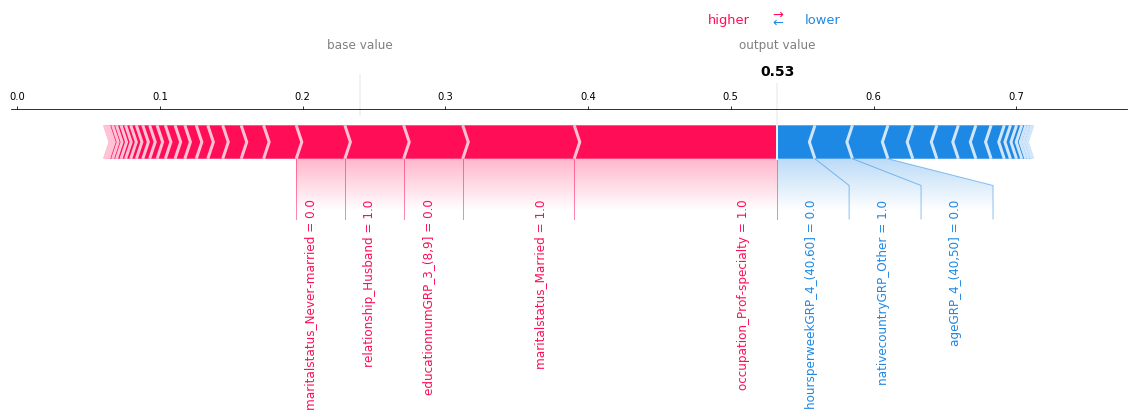

In [10]:
explainer_visual = mltk.get_explainer_visual(ImpactValues, VariableValues, Explainer, visual_config={'figsize':[20,4], 'text_rotation':90})
explainer_visual

### Generate Explain Summary

In [11]:
explainer_summary = mltk.get_shap_impact_summary(ImpactValues, VariableValues, Explainer.get_model_variables(), iloc=0, top_n=5, show_plot=True)
explainer_summary

sum_posivite_impact_values 0.47119034752388556
sum_negative_impact_values -0.1790829595786017


,Impact,NormalizedImpact,Value,Sign,Rank,Output
occupation_Prof-specialty,0.14219,0.30178,1,P,1,None
maritalstatus_Married,0.07811,0.16577,1,P,2,None
"educationnumGRP_3_(8,9]",0.04138,0.08782,0,P,3,None
relationship_Husband,0.04122,0.08748,1,P,4,None
maritalstatus_Never-married,0.03406,0.07227,0,P,5,None
"hoursperweekGRP_4_(40,60]",-0.02648,0.14786,0,N,1,None
nativecountryGRP_Other,-0.02626,0.14663,1,N,2,None
"ageGRP_4_(40,50]",-0.02489,0.13899,0,N,3,None
"ageGRP_5_(50,60]",-0.01737,0.09697,0,N,4,None
occupation_Exec-managerial,-0.01689,0.09431,0,N,5,None


In [12]:
explainer_report, explain_plot = mltk.get_explainer_report(DataFrame, Explainer, top_n=10, show_plot=True, return_type='frame')
explainer_report

sum_posivite_impact_values 0.47119034752388556
sum_negative_impact_values -0.1790829595786017


,Impact,NormalizedImpact,Value,Sign,Rank,Output
occupation_Prof-specialty,0.14219,0.30178,1,P,1,0.53248
maritalstatus_Married,0.07811,0.16577,1,P,2,0.53248
"educationnumGRP_3_(8,9]",0.04138,0.08782,0,P,3,0.53248
relationship_Husband,0.04122,0.08748,1,P,4,0.53248
maritalstatus_Never-married,0.03406,0.07227,0,P,5,0.53248
"ageGRP_2_(20,30]",0.02286,0.04853,0,P,6,0.53248
"educationnumGRP_1_(1,5]",0.01570,0.03332,0,P,7,0.53248
relationship_Own-child,0.01293,0.02744,0,P,8,0.53248
relationship_Not-in-family,0.01046,0.02219,0,P,9,0.53248
"educationnumGRP_4_(9,12]",0.00808,0.01714,0,P,10,0.53248


### Impact plot

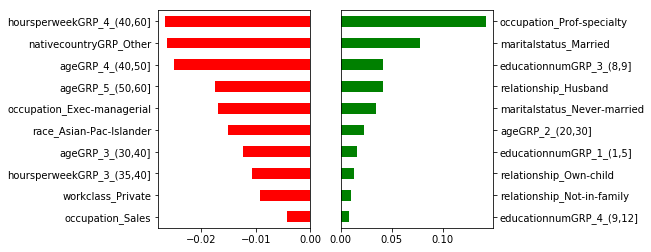

In [13]:
explain_plot

## Cite as
```
@misc{mltk2019,
  author =  "Sumudu Tennakoon",
  title = "MLToolKit(mltk): A Simplified Toolkit for Unifying End-To-End Machine Learing Projects",
  year = 2019,
  publisher = "GitHub",
  howpublished = {\url{https://mltoolkit.github.io/mltk/}},
  version = "0.1.10"
}
```

<hr>
This notebook and related materials were developed by Sumudu Tennakoon to demostrate the MLToolkit python library and its interoperability with the standared Python data analysis and machine learning packages (e.g. Pandas, Sci-kitlearn, Statsmodel, TensorFlow, Catboost, etc.)
Create Date: July 01, 2018; Last Update: December 07, 2019. 
Apache License, Version 2.0 (http://www.apache.org/licenses/LICENSE-2.0)